In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
from astropy.io import fits
from sklearn.tree import DecisionTreeRegressor
import glob
from astropy import units as u
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR


In [2]:
#Glob away all the fits in a dir
fits_list =glob.glob("sdss_fits_files/*.fits")


In [3]:
#Extra the fits tables from all the globbed fits
specdata_list=[]
for i in fits_list:
    with fits.open(i) as fit_file:
        specdata=fit_file[1].data
        header=fit_file[0].header
        specdata_list.append(specdata)

In [4]:
#Get the shapes of each spectra then find the smallest shape along 0 axis
spec_shape_list=[]
for i in specdata_list:
    spec_shape_list.append(i.shape)
spec_shape_list=np.array(spec_shape_list)
smallest_spec=np.min(spec_shape_list)

In [5]:
a=[(3.582 <= lam <= 3.957) for lam in specdata_list[0]['loglam']]
len(a)

3838

In [6]:
#Filtering routine

# Finding a target lenght for filtering
target_length = sum((3.582 <= lam <= 3.957) for lam in specdata_list[0].loglam)

spectra_filtered_list = []
for i in specdata_list:
    spec = i
    # Apply boolean mask along lambda axis from 3.582 to 3.957
    mask = (spec.loglam >= 3.582) & (spec.loglam <= 3.957)
    filtered_data = spec[mask]
    
    # Adjust the length to match target_length
    if len(filtered_data) < target_length:
        # If shorter, pad with NaNs or another value of choice and relpace missing vals with mean of the spectrum
        filtered_data = np.pad(filtered_data, (0, target_length - len(filtered_data)), constant_values=np.mean(filtered_data['sky'])) 
    elif len(filtered_data) > target_length:
        # If longer, truncate
        filtered_data = filtered_data[:target_length]
        
    spectra_filtered_list.append(filtered_data)

# Convert to numpy array now that all arrays are the same length
spectra_filtered_list = np.array(spectra_filtered_list)
spectra_filtered_list.shape

# Extract 'sky' values from each spectrum if they exist
if 'sky' in spectra_filtered_list.dtype.names:
    spectra_filtered_list_array = spectra_filtered_list['sky']


In [7]:
spectra_filtered_list_array.shape

(152, 3750)

In [8]:
#ML starts fromm here
wavebins = spectra_filtered_list_array.shape[1] #number of wavelenghts
num_spectra = spectra_filtered_list_array.shape[0] #num of spectra
fibres=np.arange(num_spectra).reshape(-1,1) #fibre indices array
master_sky_spectrum_list=[] #List to hold all master sky spectrum
score_list=[]  #scores list of prediction values for all regression methods
ml_regression_methods=[DecisionTreeRegressor(),SVR(), LinearRegression()]  #explore 3 regression methods


#ML starts here
for regres_technique in ml_regression_methods:
    master_sky_spectrum = np.zeros(wavebins) #empty array for master sky
    scores=[] #scores of prediction values
    # loop over each intensity value at a wavebin
    for i in range(wavebins):
        # Intensities for the i-th wavelength bin for all fibres
        flux_at_wavebin = spectra_filtered_list_array[:, i]

        regressor = regres_technique
        #fit the model
        regressor.fit(fibres, flux_at_wavebin)  #fibres are features, flux_at_wavebin are targets
        #predict the model
        pred_values = regressor.predict(fibres) #across all fibres make models for all of them, this makes 150 models
        #average all the models to a single master sky spectrum
        master_sky_spectrum[i] = pred_values.mean()
        #calculate the scores for each regression techniques
        scores.append(regressor.score(fibres, flux_at_wavebin))
    #append all the master sky spectrums for all the regression techniqyues
    master_sky_spectrum_list.append(master_sky_spectrum)
    score_list.append(scores)


print("Generated Master Sky Spectrum:")

"""
Experimental if instead of 0 nans are put there
# Running over each intensity value at a wavebin
for i in range(wavebins):
    # Intensities for the i-th wavelength bin for all fibers
    flux_at_wavebin = spectra_filtered_list_array[:, i]
    fibres = np.arange(num_spectra).reshape(-1, 1)
    
    # Filter out NaN values in the flux data and the corresponding fiber indices
    valid_indices = ~np.isnan(flux_at_wavebin)
    valid_fibres = fibres[valid_indices]
    valid_flux = flux_at_wavebin[valid_indices]
    
    # Ensure there are enough valid points to fit the model
    if len(valid_flux) > 1:  # At least two data points are needed to fit
        regressor = DecisionTreeRegressor(max_depth=3)
        regressor.fit(valid_fibres, valid_flux)
        pred_values = regressor.predict(valid_fibres)
        master_sky_spectrum[i] = pred_values.mean()
    else:
        master_sky_spectrum[i] = np.nan  # Assign NaN if not enough data points

print("Generated Master Sky Spectrum:", master_sky_spectrum)
"""


Generated Master Sky Spectrum:


'\nExperimental if instead of 0 nans are put there\n# Running over each intensity value at a wavebin\nfor i in range(wavebins):\n    # Intensities for the i-th wavelength bin for all fibers\n    flux_at_wavebin = spectra_filtered_list_array[:, i]\n    fibres = np.arange(num_spectra).reshape(-1, 1)\n    \n    # Filter out NaN values in the flux data and the corresponding fiber indices\n    valid_indices = ~np.isnan(flux_at_wavebin)\n    valid_fibres = fibres[valid_indices]\n    valid_flux = flux_at_wavebin[valid_indices]\n    \n    # Ensure there are enough valid points to fit the model\n    if len(valid_flux) > 1:  # At least two data points are needed to fit\n        regressor = DecisionTreeRegressor(max_depth=3)\n        regressor.fit(valid_fibres, valid_flux)\n        pred_values = regressor.predict(valid_fibres)\n        master_sky_spectrum[i] = pred_values.mean()\n    else:\n        master_sky_spectrum[i] = np.nan  # Assign NaN if not enough data points\n\nprint("Generated Master 

Text(0.5, 1.0, ' The LinearRegression() master sky')

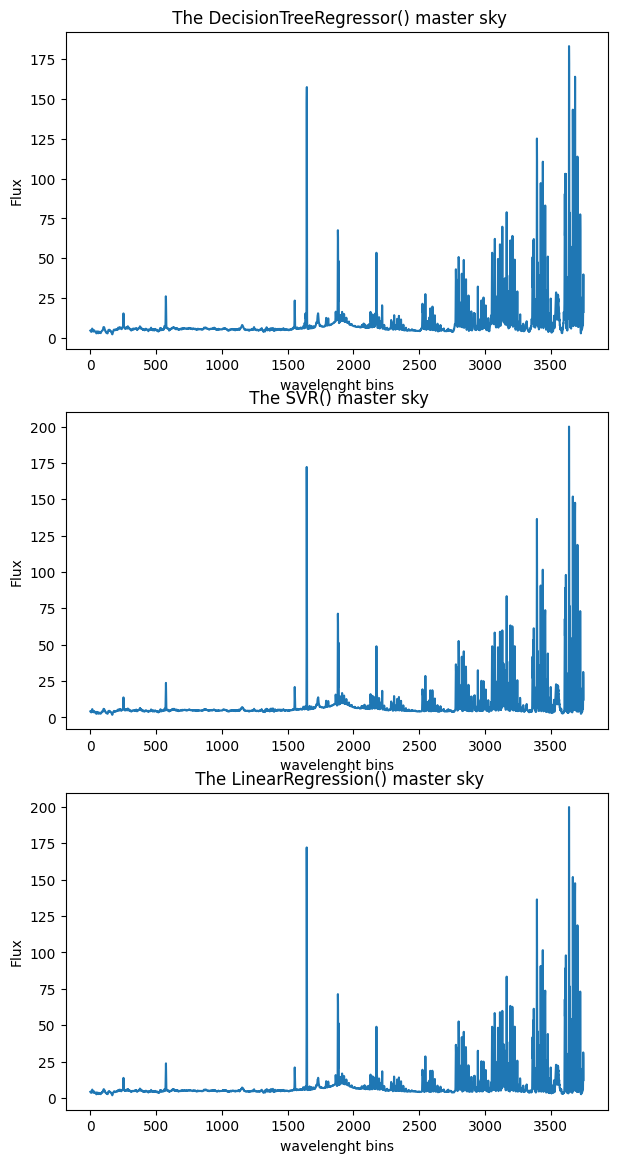

In [9]:
fig, ax=plt.subplots(nrows=3, ncols=1, figsize=(7,14))

ax[0].plot(master_sky_spectrum_list[0])
ax[0].set_xlabel('wavelenght bins')
ax[0].set_ylabel('Flux')
ax[0].set_title(f" The {ml_regression_methods[0]} master sky")

ax[1].plot(master_sky_spectrum_list[1])
ax[1].set_xlabel('wavelenght bins')
ax[1].set_ylabel('Flux')
ax[1].set_title(f" The {ml_regression_methods[1]} master sky")


ax[2].plot(master_sky_spectrum_list[1])
ax[2].set_xlabel('wavelenght bins')
ax[2].set_ylabel('Flux')
ax[2].set_title(f" The {ml_regression_methods[2]} master sky")


In [26]:
#scaling the master sky to the science spectra
ref_master= master_sky_spectrum_list[0][3600:3750]
ref_sky=spectra_filtered_list['sky'][0,3600:3750]
scaling=np.mean(ref_sky/ref_master)

scaled_master_sky_spectrum_list=[]
for i in master_sky_spectrum_list:
    master_scaled=i*scaling
    scaled_master_sky_spectrum_list.append(master_scaled)



Text(0, 0.5, 'Flux')

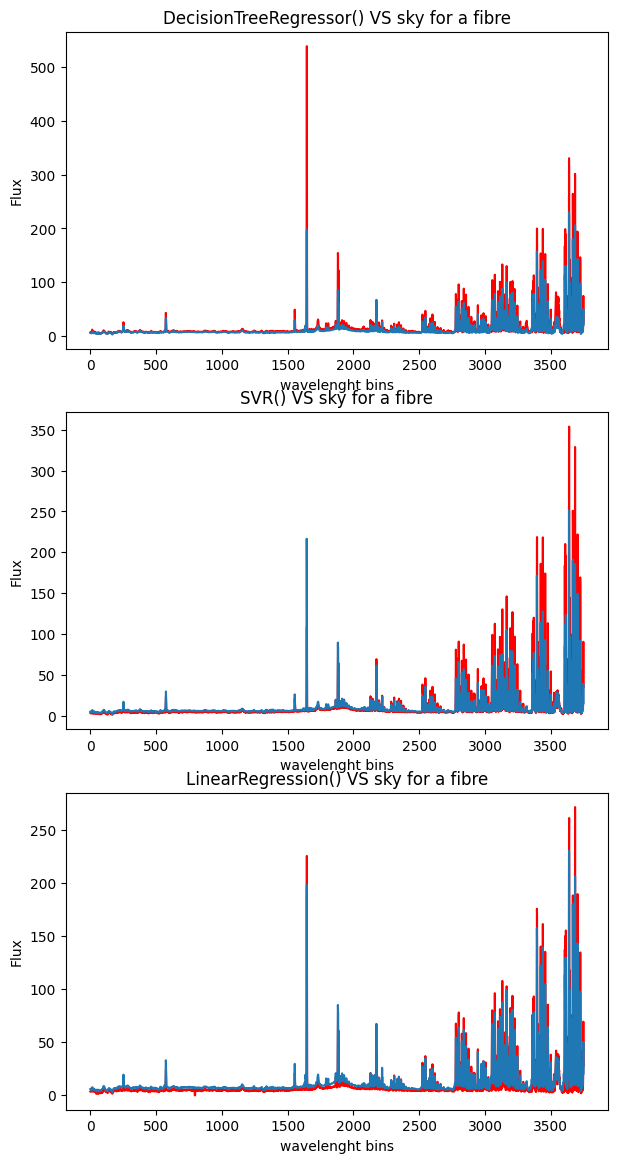

In [30]:
#scaling plots comparison

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(7,14))

ax[0].plot(spectra_filtered_list_array[0], c='r')
ax[0].plot(scaled_master_sky_spectrum_list[0])
ax[0].set_title( f"{ml_regression_methods[0]} VS sky for a fibre")
ax[0].set_xlabel('wavelenght bins')
ax[0].set_ylabel('Flux')

ax[1].plot(spectra_filtered_list_array[1], c='r')
ax[1].plot(scaled_master_sky_spectrum_list[1])
ax[1].set_title( f"{ml_regression_methods[1]} VS sky for a fibre")
ax[1].set_xlabel('wavelenght bins')
ax[1].set_ylabel('Flux')

ax[2].plot(spectra_filtered_list_array[2], c='r')
ax[2].plot(scaled_master_sky_spectrum_list[2])
ax[2].set_title( f"{ml_regression_methods[2]} VS sky for a fibre")
ax[2].set_xlabel('wavelenght bins')
ax[2].set_ylabel('Flux')




